In [1]:
from pyomo.environ import *
from matplotlib import pyplot as plt
import numpy as np


from utils.model import init_model, getM1_rule, getM2_rule
from utils.data import load_data, slope_bounds, intercept_bounds

In [2]:
data = load_data('Data/DebrisFlow.txt')

CL, CU = slope_bounds(data)
DL, DU = intercept_bounds(data)

C:\Users\padidar\Desktop\CO-Project-Pyomo\utils\data.py:17: RuntimeWarning: invalid value encountered in divide
  slope_min = np.nanmin((y[:, None] - y[None, :]) / (x[:, None] - x[None, :]))
C:\Users\padidar\Desktop\CO-Project-Pyomo\utils\data.py:18: RuntimeWarning: invalid value encountered in divide
  slope_max = np.nanmax((y[:, None] - y[None, :]) / (x[:, None] - x[None, :]))


In [3]:
b = 4
model = init_model(data)
model.b = Param(initialize=b)
model.B_ = RangeSet(1, b-1)
model.M1 = Param(model.I, initialize=getM1_rule(data))
model.M2 = Param(model.I, initialize=getM2_rule(data))

model.c = Var(model.B_, within=Reals, bounds=(CL, CU))
model.d = Var(model.B_, within=Reals, bounds=(DL, DU))

model.e = Var(model.I, within=NonNegativeReals)
model.x = Var(model.I, model.B_, within=Binary)

model.x_plus = Var(model.I, model.B_, within=Reals, bounds=(0, 1))
model.x_minus = Var(model.I, model.B_, within=Reals, bounds=(0, 1))
model.gamma = Var(model.B_, within=Binary)

In [4]:
@model.Constraint(model.I, model.B_)
def error_constraint_leq(model, i, b):
    return model.Y[i] - model.c[b] * model.X[i] - model.d[b] <= model.e[i] + model.M1[i] * (1 - model.x[i, b])


@model.Constraint(model.I, model.B_)
def error_constraint_geq(model, i, b):
    return model.Y[i] - model.c[b] * model.X[i] - model.d[b] >= -model.e[i] - model.M1[i] * (1 - model.x[i, b])


@model.Constraint(model.I)
def assignment_constraint(model, i):
    return sum(model.x[i, b] for b in model.B_) == 1

#
@model.Constraint(model.I, model.B_)
def ordering_constraint(model, i, b):
    if i == model.n or b == model.b-1:
        return Constraint.Skip
    return model.x[i + 1, b + 1] <= model.x[i, b] + model.x[i, b + 1]


@model.Constraint(model.I)
def ordering_one_constraint(model, i):
    if i == model.n:
        return Constraint.Skip
    return model.x[i + 1, 1] <= model.x[i, 1]


@model.Constraint(model.I)
def ordering_last_constraint(model, i):
    if i == model.n:
        return Constraint.Skip
    return model.x[i, model.b-1] <= model.x[i + 1, model.b-1]

#
@model.Constraint(model.I, model.B_)
def pos_slope_constraint(model, i, b):
    if i == model.n or b == model.b-1:
        return Constraint.Skip
    return model.x[i, b] + model.x[i + 1, b + 1] + model.gamma[b] - 2 <= model.x_plus[i, b]


@model.Constraint(model.I, model.B_)
def neg_slope_constraint(model, i, b):
    if i == model.n or b == model.b-1:
        return Constraint.Skip
    return model.x[i, b] + model.x[i + 1, b + 1] - model.gamma[b] - 1 <= model.x_minus[i, b]

#
@model.Constraint(model.I, model.B_)
def pos_slope_constraint_geq(model, i, b):
    if i == model.n or b == model.b-1:
        return Constraint.Skip
    return model.d[b+1] - model.d[b] >= model.X[i] * (model.c[b] - model.c[b+1]) - model.M2[i] * (1 - model.x_plus[i, b])


@model.Constraint(model.I, model.B_)
def pos_slope_constraint_leq(model, i, b):
    if i == model.n or b == model.b-1:
        return Constraint.Skip
    return model.d[b+1] - model.d[b] <= model.X[i+1] * (model.c[b] - model.c[b+1]) + model.M2[i+1] * (1 - model.x_plus[i, b])


@model.Constraint(model.I, model.B_)
def neg_slope_constraint_leq(model, i, b):
    if i == model.n or b == model.b-1:
        return Constraint.Skip
    return model.d[b+1] - model.d[b] <= model.X[i] * (model.c[b] - model.c[b+1]) + model.M2[i] * (1 - model.x_minus[i, b])


@model.Constraint(model.I, model.B_)
def neg_slope_constraint_geq(model, i, b):
    if i == model.n or b == model.b-1:
        return Constraint.Skip
    return model.d[b+1] - model.d[b] >= model.X[i+1] * (model.c[b] - model.c[b+1]) - model.M2[i+1] * (1 - model.x_minus[i, b])


model.obj = Objective(expr=sum(model.e[i] for i in model.I))

In [5]:
import time
t = []

for i in range(10):    
    t.append(time.time())
    result = SolverFactory('glpk', tee=True, keepfiles=False).solve(model)

    if result.solver.termination_condition != TerminationCondition.optimal:
        raise Exception('Solver did not find an optimal solution')
    t[i] = time.time() - t[i]
    print(f'Requiered Time {i}: {t[i]}')

print(f'Objective: {model.obj():.2f}')
print(f'Average Requiered Time: {sum(t)/10}')

Requiered Time 0: 1.6884868144989014
Requiered Time 1: 1.653303623199463
Requiered Time 2: 1.677656650543213
Requiered Time 3: 1.6830785274505615
Requiered Time 4: 1.5830285549163818
Requiered Time 5: 1.6158761978149414
Requiered Time 6: 1.579233169555664
Requiered Time 7: 1.5889465808868408
Requiered Time 8: 1.5801990032196045
Requiered Time 9: 1.5803608894348145
Objective: 27.15
Average Requiered Time: 1.6230170011520386


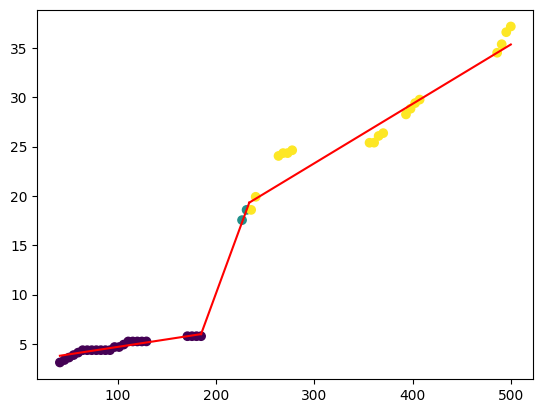

In [6]:
data_clusters = np.array([sum(model.x[i, b].value * (b - 1) for b in model.B_) for i in model.I])

breakpoints = [data[0, 0]]
for b in model.B_:
    if b != model.b - 1:
        r = (model.d[b + 1].value - model.d[b].value) / (model.c[b].value - model.c[b + 1].value)
        breakpoints.append(r)
breakpoints.append(np.max(data[data_clusters == model.b - 2, 0]))

plt.scatter(data[:, 0], data[:, 1], c=data_clusters)
for b in model.B_:
    plt.plot([breakpoints[b - 1], breakpoints[b]], [model.c[b].value * breakpoints[b - 1] + model.d[b].value, model.c[b].value * breakpoints[b] + model.d[b].value], color='red')
plt.show()